In [64]:
# Modules

# General functionality and file manipulation
import os
from datetime import datetime

# Data Processing
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

## Plotting data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

# MNIST - Classical MLP

Implementation in Pytorch of MLP Neural Network.

## (Quick) EDA

In [65]:
df = pd.read_csv('data/train.csv')

In [66]:
print(f'How many obs: {df.shape}')
print(df.dtypes)
print(df.head())
print(df.columns)


How many obs: (42000, 785)
label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0   

In [67]:
a = df.iloc[0, :]
print('label' in a.index.tolist())

True


(784,)
(28, 28)


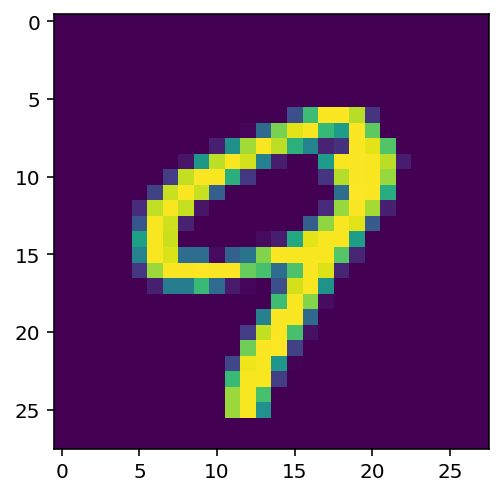

In [68]:
ex = df.iloc[100, 1:].to_numpy()
print(ex.shape)
ex.shape = (np.sqrt(784).astype('int'), -1) 
print(ex.shape)
plt.imshow(ex)

## Data Processing

### DataLoader and Transformations

In [69]:
class NumberImagePixel(Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        self.predict_data = not ('label' in df.columns.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        row = self.df.iloc[idx]

        if self.predict_data:
            label = -1
            features = row.to_numpy()
        else:
            label = row['label']
            features = row.drop(labels='label').to_numpy()
            
        row = {'label': label, 'features': features}
        
        if self.transform:
            row = self.transform(row)
        
        return row 
        
        

In [70]:
class Normalization(object):
    """ Normalise by mean and stdv"""
    
    def __call__(self, sample):
        label, feat = sample['label'], sample['features']
        
        feat = feat/255 #(feat - np.mean(feat))/np.std(feat)
        
        return {'label': label,
               'features': feat}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        label, features = sample['label'], sample['features']

        # If data is to be predicted.
        if label == -1:
            return {'label': label,
               'features': torch.from_numpy(features).type(torch.FloatTensor)}

        return {'label': torch.from_numpy(np.array(label)).type(torch.LongTensor),
               'features': torch.from_numpy(features).type(torch.FloatTensor)}

In [71]:
def make_dataloader(df, batch_size):
    data = NumberImagePixel(df=df,
                            transform=transforms.Compose([Normalization(),
                                                          ToTensor()]))
    dataloader = DataLoader(data, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    return dataloader

In [72]:
batch_size = 128
df_train = pd.read_csv('data/train.csv')
X_train, X_validation, y_train, y_validation = train_test_split(df_train[[col for col in df.columns if col != 'label']],
                                                                df_train['label'],
                                                                test_size = 0.1)

X_train['label'] = y_train
X_validation['label'] = y_validation


df_train = X_train
df_validation = X_validation
df_test = pd.read_csv('data/test.csv')
print('label' in df_train.columns.tolist())

dataloader = {}
names = ['train', 'validation', 'test']
for idx, df in enumerate([df_train, df_validation, df_test]):
    dataloader.update({names[idx]: make_dataloader(df, batch_size)})

True


In [73]:
for data in iter(dataloader['test']):
    print(data)
    print(f'label {data["label"].shape}')
    print(f'feat {data["features"].shape}')
    break

{'label': tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1]), 'features': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
label torch.Size([128])
feat torch.Size([128, 784])


In [74]:
for data in iter(dataloader['train']):
    print(data)
    print(f'label {data["label"].shape}')
    print(f'feat {data["features"].shape}')
    break

{'label': tensor([1, 4, 1, 4, 5, 9, 3, 7, 3, 2, 8, 9, 4, 6, 8, 7, 1, 0, 1, 1, 8, 4, 9, 1,
        6, 1, 0, 1, 9, 9, 2, 4, 0, 3, 0, 3, 7, 2, 5, 7, 2, 9, 2, 3, 9, 9, 9, 6,
        8, 4, 3, 7, 0, 7, 9, 1, 4, 7, 8, 9, 8, 2, 4, 0, 1, 0, 5, 9, 4, 0, 1, 5,
        0, 4, 2, 4, 4, 7, 3, 1, 4, 4, 4, 9, 7, 1, 6, 6, 4, 4, 5, 7, 5, 4, 3, 7,
        3, 5, 8, 7, 9, 0, 8, 9, 8, 2, 1, 3, 4, 2, 5, 0, 7, 8, 7, 8, 2, 2, 5, 7,
        1, 7, 9, 9, 1, 1, 6, 2]), 'features': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
label torch.Size([128])
feat torch.Size([128, 784])


## Neural Network

### Neural Net. Architecture

In [75]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 Hidden Layer Network
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.2)
        # Add softmax on output layer
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = self.log_softmax(self.fc5(x), dim=1)
        
        return x

### Training the model

In [76]:
def train_model(model, dataloader,
                criterion, optimizer,
                n_epoch=10, path_to_save='model.pt', 
                print_every=None):
    """
    Train our Neural Network with data and return the trained model,
    the plot diagnostics and also save the model in the path_to_save.
    
    Args:
    dataloader (dict): contains train dataloader and validation dataloader.
    path_to_save (str): path to save the model parameters in the .pt format.
    
    Returns:
    model: model trained with model.eval() = True.
    """
    # Checking if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cpu_or_gpu = ('GPU' if torch.cuda.is_available() else 'CPU')
    print(f"Running training on {cpu_or_gpu}")
    model = model.to(device)

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to +infinity

    train_losses = []
    valid_losses = []
    
    if print_every is None:
        print_every = int(n_epoch * 0.1) + 1
        
    for epoch in range(1, n_epoch + 1):
        
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        # prep model for training
        model.train() 
        print('\n Training Loss...')
        turn = 0
        for data in dataloader['train']:

            x_train = data['features'].to(device)
            y_train = data['label'].to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(x_train) 
            # calculate the loss
            loss = criterion(output, y_train)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()
            
            turn += 1
            if turn % print_every == 0:
                print(f'Turn {turn}: {train_loss}')


        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        print("\n Validation Loss...")
        turn = 0
        for data in dataloader['validation']:
            x_validation = data['features'].to(device)
            y_validation = data['label'].to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(x_validation) # log_ps
            # calculate the loss
            loss = criterion(output, y_validation) 
            # update running validation loss 
            valid_loss += loss.item()

            turn += 1
            if turn % print_every == 0:
                print(f'Turn {turn}: {train_loss} \n')

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(dataloader['train'])
        train_losses.append(train_loss)
        valid_loss = valid_loss/len(dataloader['validation'])
        valid_losses.append(valid_loss)

        print(f"""
            Epoch: {epoch}
            \tTraining Loss: {round(train_loss, 6)}
            \tValidation Loss: {round(valid_loss, 6)}
            """)

        # save model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f'Validation loss decreased \
                ({round(valid_loss_min,6)} --> {round(valid_loss,6)}).\
                    Saving model ...')
            torch.save(model.state_dict(), path_to_save)
            valid_loss_min = valid_loss
    
    # Plotting train and validation losses.
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    
    return model

Running training on GPU

 Training Loss...
Turn 50: 61.02150809764862
Turn 100: 84.33149832487106
Turn 150: 102.33112193644047
Turn 200: 116.29680436849594
Turn 250: 128.32826159149408

 Validation Loss...

            Epoch: 1
            	Training Loss: 0.470427
            	Validation Loss: 0.206933
            
Validation loss decreased                 (inf --> 0.206933).                    Saving model ...

 Training Loss...
Turn 50: 10.527121767401695
Turn 100: 19.070094887167215
Turn 150: 27.241428581997752
Turn 200: 35.288955545052886
Turn 250: 43.058913661167026

 Validation Loss...

            Epoch: 2
            	Training Loss: 0.166339
            	Validation Loss: 0.151473
            
Validation loss decreased                 (0.206933 --> 0.151473).                    Saving model ...

 Training Loss...
Turn 50: 7.095607008785009
Turn 100: 13.506888065487146
Turn 150: 19.342438127845526
Turn 200: 25.268946390599012
Turn 250: 31.5006122328341

 Validation Loss...

     

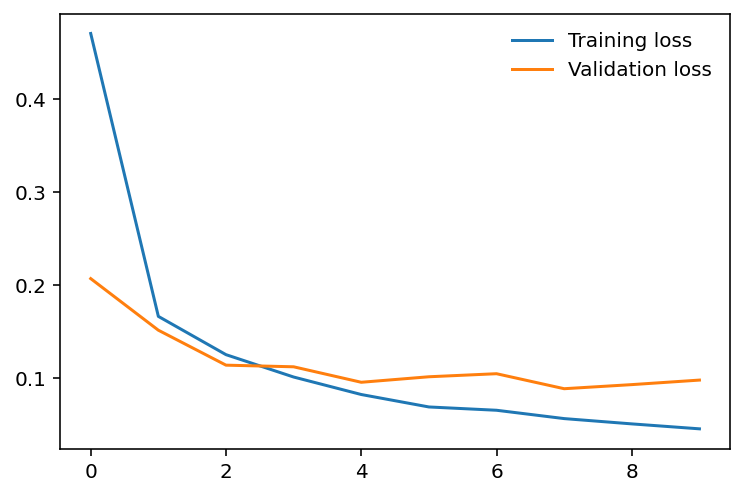

In [77]:
model = MultiClassifier()
# Define our loss function
criterion = nn.NLLLoss()
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=0.0015)

model = train_model(model=model, n_epoch = 10, dataloader=dataloader,criterion=criterion, optimizer=optimizer, print_every=50)

### Predict new dataset

Prob tensor([[0.9999]], device='cuda:0'), 
 Class: tensor([[6]], device='cuda:0')
(28, 28)


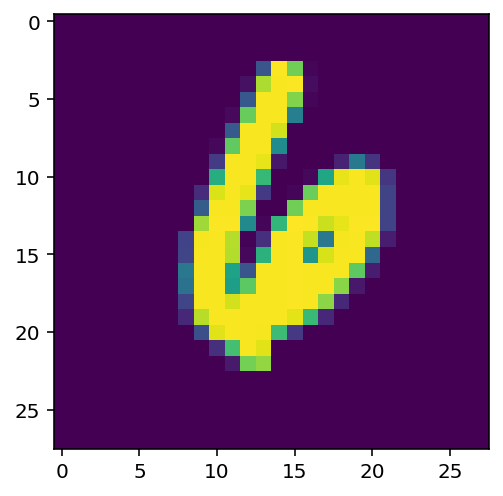

In [78]:
def predict(model, data):
    model.eval() # prepare model for evaluation
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # To speed up calculations, forget the gradients, etc.
    with torch.no_grad():
        x_cpu = data
        x = data.to(device)
        output = model(x)
        output = torch.exp(output)
        top_p, top_class = output.topk(1, dim=1)
        print(f'Prob {top_p}, \n Class: {top_class}')
        x = x_cpu.view(np.sqrt(784).astype('int'), -1)
        x = x.numpy() * 300
        print(x.shape)
        plt.imshow(x)
        plt.show()

for data in dataloader['test']:
    data = data['features'][0:1,]
    predict(model, data)
    break